## Let's create Linear Regression Model and use GPU for training, evaluations and inference

In [251]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.7.1+cu118'

In [252]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Data

In [253]:
weight = 7
bias = 3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X.device, y.device, len(X), len(y), X[:10], y[:10]

(device(type='cpu'),
 device(type='cpu'),
 50,
 50,
 tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[3.0000],
         [3.1400],
         [3.2800],
         [3.4200],
         [3.5600],
         [3.7000],
         [3.8400],
         [3.9800],
         [4.1200],
         [4.2600]]))

### Split data

In [254]:
# 80% training and 20% testin
train_split = int(len(X) * 0.8)

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualize data

In [255]:
def plot_predictions(train_data = X_train,
                     train_label = y_train,
                     test_data = X_test,
                     test_label = y_test,
                     predictions = None):
    
    """
    Plots the training, test and predictions
    """

    plt.scatter(train_data, train_label, c='r', s=4, label="Training data")

    plt.scatter(test_data, test_label, c='b', s=4, label="Testing data")

    if predictions is not None :

        plt.scatter(test_data, predictions, c='black', s=4, label="Predictions")

    plt.legend(prop={"size" : 14})

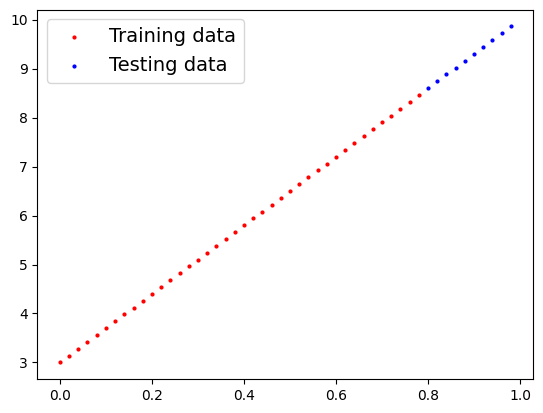

In [256]:
plot_predictions(train_data=X_train,
                 train_label=y_train,
                 test_data=X_test,
                 test_label=y_test)

## Defining model architecture

In [257]:
class LinearRegressionModelV2(nn.Module):

    def __init__(self):

        super().__init__()

        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
        
    def forward(self, x: torch.tensor) -> torch.tensor:

        return self.linear_layer(x)

In [258]:
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### Let's check is model is using cpu

In [259]:
print(f"Model is on: {next(model_1.parameters()).device}")
print(f"Model parameters are: {next(model_1.parameters()).dtype}")

Model is on: cpu
Model parameters are: torch.float32


### Let's use GPU for this model

In [260]:
model_1.to(device)
print(f"Model is on: {next(model_1.parameters()).device}")

Model is on: cuda:0


### Loss function and optimizer for model

In [261]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

### Put data on the GPU

In [262]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train.device, y_train.device, X_test.device, y_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [263]:
def Fit(epochs):

    train_loss_values = []
    test_loss_values = []
    epoch_count = []

    for epoch in range(epochs):

        model_1.train()

        train_preds = model_1(X_train)
        
        train_loss = loss_fn(train_preds, y_train)

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        ## Testing

        model_1.eval()

        with torch.inference_mode():

            test_preds = model_1(X_test)
            test_loss = loss_fn(test_preds, y_test.type(torch.float))

            if epoch % 10 == 0:

                train_loss_values.append(train_loss.detach().cpu())
                test_loss_values.append(test_loss.detach().cpu())
                epoch_count.append(epoch)

                print(f"Epoch: {epoch} -----| MAE Train Loss: {train_loss} -----| MAE Test Loss: {test_loss}")

    return epoch_count, train_loss_values, test_loss_values

In [264]:
epoch_count, train_loss_values, test_loss_values = Fit(3500)

Epoch: 0 -----| MAE Train Loss: 4.6018218994140625 -----| MAE Test Loss: 7.706082344055176
Epoch: 10 -----| MAE Train Loss: 4.486611843109131 -----| MAE Test Loss: 7.5713725090026855
Epoch: 20 -----| MAE Train Loss: 4.371402263641357 -----| MAE Test Loss: 7.436662197113037
Epoch: 30 -----| MAE Train Loss: 4.256192684173584 -----| MAE Test Loss: 7.301952362060547
Epoch: 40 -----| MAE Train Loss: 4.140982627868652 -----| MAE Test Loss: 7.167242527008057
Epoch: 50 -----| MAE Train Loss: 4.025772571563721 -----| MAE Test Loss: 7.032533168792725
Epoch: 60 -----| MAE Train Loss: 3.9105629920959473 -----| MAE Test Loss: 6.897822856903076
Epoch: 70 -----| MAE Train Loss: 3.7953526973724365 -----| MAE Test Loss: 6.763112545013428
Epoch: 80 -----| MAE Train Loss: 3.680142641067505 -----| MAE Test Loss: 6.628402233123779
Epoch: 90 -----| MAE Train Loss: 3.5649325847625732 -----| MAE Test Loss: 6.493691921234131
Epoch: 100 -----| MAE Train Loss: 3.4497222900390625 -----| MAE Test Loss: 6.358981609

### Plot the losses

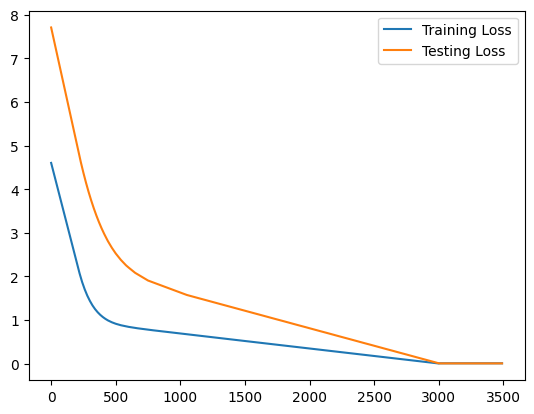

In [265]:
plt.plot(epoch_count, train_loss_values, label="Training Loss")
plt.plot(epoch_count, test_loss_values, label="Testing Loss")
plt.legend()


In [266]:
model_1.state_dict()


OrderedDict([('linear_layer.weight', tensor([[6.9981]], device='cuda:0')),
             ('linear_layer.bias', tensor([3.0090], device='cuda:0'))])

In [267]:
model_1.eval()

with torch.inference_mode():

    y_pred = model_1(X_test)
y_pred

tensor([[8.6075],
        [8.7474],
        [8.8874],
        [9.0273],
        [9.1673],
        [9.3073],
        [9.4472],
        [9.5872],
        [9.7272],
        [9.8671]], device='cuda:0')

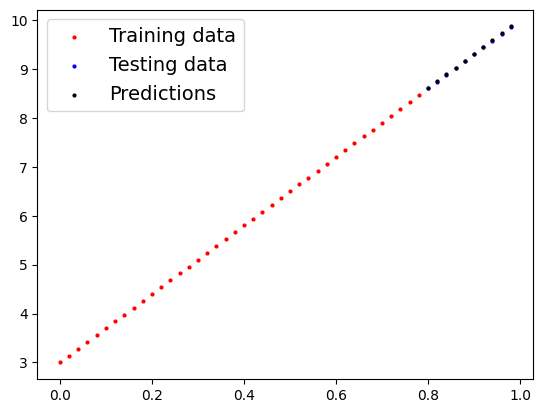

In [273]:
plot_predictions(train_data=X_train.cpu(),
                 train_label=y_train.cpu(),
                 test_data=X_test.cpu(),
                 test_label=y_test.cpu(),
                 predictions=y_pred.cpu())

In [274]:
from pathlib import Path

# Create folder
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = Path("02_linear_regression_v2.pt")
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save model

print(f"Saving model: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model: models\02_linear_regression_v2.pt


In [275]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [282]:
loaded_model_1.to(device)

loaded_y_red= loaded_model_1(X_test)

loaded_y_red == y_pred,

(tensor([[True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True]], device='cuda:0'),)